 #### 1. Extracting the data
 
 #### 2. Exploring the data
 
    2.1 Checking the missing values
    
    2.2 Checking the data types

    2.3 Investigating the negativ values of quantity
 #### 3. Analysing the Data

    3.1 the top ten most popular geographical locations 

        a. based of frequency

        b. based of quantity
       
        c. based of total_order_value
        
    3.2 Seasonality

        a. Distribution of invoices per year

        b. Distribution of invoices per month

        c. Distribution of invoices per weekday

        d. Distribution of invoices per daytimes

### 1. Extracting the data

In [2]:
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import boto3
from io import StringIO

import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

from dotenv import load_dotenv
load_dotenv()  # only for local testing


dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [4]:
# defined a Python function that establishes a connection to a Redshift database 
def connect_to_redshift(dbname, host, port, user, password):
    """definition to connect to redshift"""

    connect = psycopg2.connect(
            dbname=dbname, host=host, port=port, user=user, password=password
        )

    cursor = connect.cursor()
    
    print("connection to redshift made")
    
    return connect, cursor

In [5]:
# connect to redshift using the definition
connect, cursor = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
# a simple SQL query to select all columns from the table "online_transactions_cleaned"
query="""select *
        from bootcamp.online_transactions_cleaned otc"""

In [7]:
#read the result into a Pandas DataFrame
online_transactions_cleaned=pd.read_sql(query,connect)

In [8]:
# display the first five rows of the data
online_transactions_cleaned.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,1.25,24,30.00,2010-12-01 08:45:00,u12583,France
1,536385,22783,SET 3 WICKER OVAL BASKETS W LIDS,19.95,1,19.95,2010-12-01 09:56:00,u1742,United Kingdom
2,536392,22128,PARTY CONES CANDY ASSORTED,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom
3,536404,22469,HEART OF WICKER SMALL,1.65,12,19.80,2010-12-01 11:29:00,u16218,United Kingdom
4,536412,22274,FELTCRAFT DOLL EMILY,2.95,2,5.90,2010-12-01 11:49:00,u1792,United Kingdom


In [9]:
online_transactions_neg_price=online_transactions_cleaned[online_transactions_cleaned['price']<0]
print(f"The number of invoices with a negativ price is:{online_transactions_neg_price.shape[0]}")

The number of invoices with a negativ price is:0


### 2. Exploring the data

#### Some basic informations of the data

In [28]:
print("Number of unique invoices:", len(online_transactions_cleaned.invoice.unique()))
print("Number of unique Stock codes:", len(online_transactions_cleaned.stock_code.unique()))
print("Number of Customers:", len(online_transactions_cleaned.customer_id.unique()))
print("Number of Geographical Locations:", len(online_transactions_cleaned.country.unique()))

Number of unique invoices: 21791
Number of unique Stock codes: 3679
Number of Customers: 4363
Number of Geographical Locations: 37


In [30]:
# statistical summary for each numerical column
online_transactions_cl.describe()

,price,quantity,total_order_value,invoice_date
count,391334.000000,391334.000000,391334.000000,391334
mean,2.920468,13.174199,22.372879,2011-07-10 19:43:29.284907520
min,0.000000,1.000000,0.000000,2010-12-01 08:26:00
25%,1.250000,2.000000,4.950000,2011-04-07 11:16:00
50%,1.950000,6.000000,11.900000,2011-07-31 12:08:00
75%,3.750000,12.000000,19.800000,2011-10-20 12:57:00
max,1599.260000,80995.000000,168469.600000,2011-12-09 12:50:00
std,7.267548,181.871884,310.911086,NaN


#### 2.1 Checking the missing values

In [10]:
# checking for missing values
online_transactions_cleaned.isnull().sum()

invoice              0
stock_code           0
description          0
price                0
quantity             0
total_order_value    0
invoice_date         0
customer_id          0
country              0
dtype: int64

#### 2.2 Checking the data types

In [11]:
# checking data types of each column
online_transactions_cleaned.dtypes

invoice                      object
stock_code                   object
description                  object
price                       float64
quantity                      int64
total_order_value           float64
invoice_date         datetime64[ns]
customer_id                  object
country                      object
dtype: object

#### 2.3 Investigating the negativ values of quantity

In [14]:
# Filtering the invoices starting with 'C' 
online_transactions_c = online_transactions_cleaned[online_transactions_cleaned['invoice'].str.startswith('C', na=False)]
online_transactions_c.head()                                                  

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country
206,C536850,22186,RED STAR CARD HOLDER,2.55,-48,-122.40,2010-12-03 09:47:00,u14213,United Kingdom
228,C536815,22178,VICTORIAN GLASS HANGING T-LIGHT,1.25,-1,-1.25,2010-12-02 17:05:00,u14443,United Kingdom
264,C536850,22591,CARDHOLDER GINGHAM CHRISTMAS TREE,2.55,-50,-127.50,2010-12-03 09:47:00,u14213,United Kingdom
345,C536625,22839,3 TIER CAKE TIN GREEN AND CREAM,14.95,-2,-29.90,2010-12-02 10:46:00,u14766,United Kingdom
394,C536807,22778,GLASS BELL JAR SMALL,3.95,-1,-3.95,2010-12-02 16:45:00,u15834,United Kingdom


In [15]:
# calculat the number of Invoices starting with 'C'
print(f"The number of invoices starting with 'C'is: {online_transactions_c.shape[0]}")

The number of invoices starting with 'C'is: 8507


In [16]:
# Calculat the number of invoices with a negativ quantity
online_transactions_neg=online_transactions_cleaned[online_transactions_cleaned['quantity']<0]
print(f"The number of invoices with a negativ quantity is:{online_transactions_neg.shape[0]}")

The number of invoices with a negativ quantity is:8507


#### the number of invoices with a negativ quantity is equal to the number of Invoices starting with 'C'. That means, that the invoices starting with 'C' have a negativ quantity.this represent returns or cancelled Items.
#### In this case, we have to ask a question:
#### Are this, befor cancelling, purchased Item with the positiv value of quantity also cancelled?
#### we assume, that this invoices have the same numerals as the numerals of cancelled invoices without 'C'.
#### Let's check that..

In [20]:
online_transactions_cleaned_ex = pd.DataFrame(online_transactions_cleaned)

#Extract the numerals from 'invoice' for invoices starting with 'C' 
online_transactions_cleaned_ex['extracted_number'] = online_transactions_cleaned_ex['invoice'].str.extract('C(\d+)', expand=False)

# Compare the extracted numerals with the 'invoice' numerals and filter matching rows
c_plus_same_number_invoices = online_transactions_cleaned_ex[online_transactions_cleaned['extracted_number'] == online_transactions_cleaned_ex['invoice']]

print(f"The number of invoices with identical numerals to the numerals of cancelled invoices without 'C' is: {len(c_plus_same_number_invoices)}")

The number of invoices with identical numerals to the numerals of cancelled invoices without 'C' is: 0


#### If the invoices with a positive value of quantity have the same numerals as the numerals of cancelled invoices without 'C',  we proved, taht this are alredy cancelled.
#### If not. We have to find pairs of transactions where the quantity values are equal in magnitude but opposite in sign (e.g., one positive and one negative) for the same customer and stock code.
#### Let's try this

In [21]:
# using the groupby function to group the data based on the 'customer_id', 'stock_code',and the absolute value of 'quantity'. 
# Then, using the filter method to select groups that meet specific conditions:
##calculates the absolute value of the quantity attribute and checks if its length is an even 
##Ensures that the sum of the quantity values is zero.
c_pairs =online_transactions_cleaned.groupby([online_transactions_cleaned.customer_id, 
                                        online_transactions_cleaned.stock_code, 
                                        online_transactions_cleaned.quantity.abs()])\
                                        .filter(lambda x: (len(x.quantity.abs()) % 2 == 0) and (x.quantity.sum() == 0))

In [24]:
# display the first five rows of the data
c_pairs.sort_values(by='price', ascending= False).head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,extracted_number
41767,543253,22655,VINTAGE RED KITCHEN CABINET,295.0,1,295.0,2011-02-04 15:32:00,u14842,United Kingdom,NaN
117430,C539438,22655,VINTAGE RED KITCHEN CABINET,295.0,-1,-295.0,2010-12-17 15:11:00,u16607,United Kingdom,539438
19810,539080,22655,VINTAGE RED KITCHEN CABINET,295.0,1,295.0,2010-12-16 08:41:00,u16607,United Kingdom,NaN
187925,C543632,22655,VINTAGE RED KITCHEN CABINET,295.0,-1,-295.0,2011-02-10 16:22:00,u14842,United Kingdom,543632
31032,540647,22655,VINTAGE RED KITCHEN CABINET,295.0,1,295.0,2011-01-10 14:57:00,u17406,United Kingdom,NaN


In [25]:
# Display of a example of pairs With the same description,customer_id, country and opposite sign of quantity
c_pairs_Vin = c_pairs[(c_pairs['description'] == 'VINTAGE RED KITCHEN CABINET') & (c_pairs['customer_id']=='u16607')]
c_pairs_Vin

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,extracted_number
19810,539080,22655,VINTAGE RED KITCHEN CABINET,295.0,1,295.0,2010-12-16 08:41:00,u16607,United Kingdom,NaN
117430,C539438,22655,VINTAGE RED KITCHEN CABINET,295.0,-1,-295.0,2010-12-17 15:11:00,u16607,United Kingdom,539438


In [26]:
# The number of pairs
c_pairs ['quantity'].count()

4026

#### In order to adopt this assumption, we need more informations. E.g whether the cancelled orders were noted with a different invoice ID.
#### For our analysis, only the negative values in the quantity are not taken into account.


In [27]:
## Filtering invoices with a negativ value of quantity
online_transactions_cl=online_transactions_cleaned[online_transactions_cleaned['quantity']>0]

print(f"number of invoices befor filtering invoices with a negativ quantity is:{len(online_transactions_cleaned)}")

print(f"number of invoices after filtering invoices with a negativ quantity is:{len(online_transactions_cl)}")

number of invoices befor filtering invoices with a negativ quantity is:399841
number of invoices after filtering invoices with a negativ quantity is:391334


### 3. Analysing the Data
#### 3.1 the top ten most popular geographical locations 
##### a. based of frequency

In [51]:
# get the count of unique values in the 'country' column 
online_transactions_cl['country'].value_counts(dropna=False).iloc[0:10]
# or
# online_transactions_cl.country.value_counts().head(10)

country
United Kingdom    348940
Germany             8644
France              8021
EIRE                7226
Spain               2418
Netherlands         2326
Belgium             1935
Switzerland         1811
Portugal            1416
Australia           1183
Name: count, dtype: int64

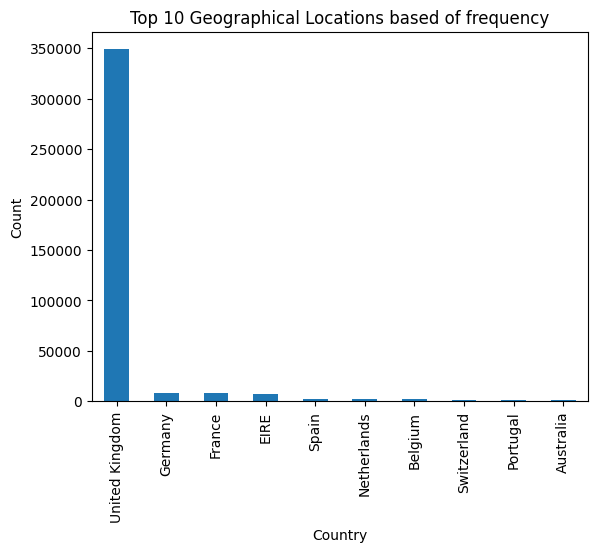

In [27]:
# Visualising the results
online_transactions_cl.country.value_counts().head(n = 10).plot(kind = 'bar')
plt.title("Top 10 Geographical Locations based of frequency")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show();

##### b. based of quantity

In [28]:
# group the data by the 'country' column and then calculate the sum of the 'quantity' for each group. 
online_transactions_cl.groupby ('country')['quantity'].sum().sort_values(ascending=False).head(10)

country
United Kingdom    4246787
Netherlands        200834
EIRE               140381
Germany            118033
France             110597
Australia           84198
Sweden              36037
Switzerland         29981
Spain               27735
Japan               26016
Name: quantity, dtype: int64

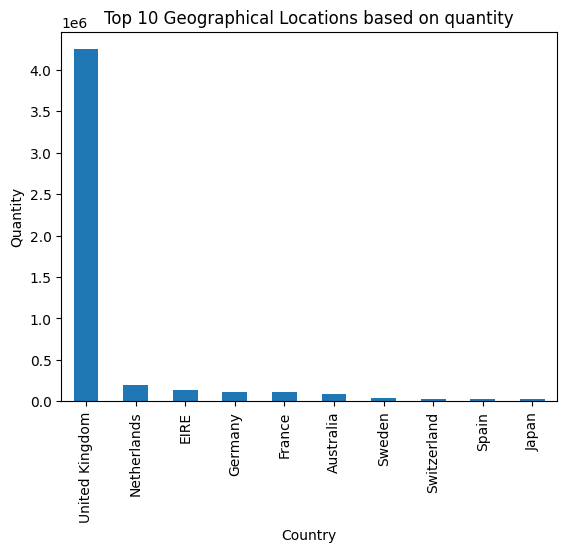

In [29]:
# Visualising the results
online_transactions_cl.groupby ('country')['quantity'].sum().sort_values(ascending=False).head(10).plot(kind = 'bar')
plt.title("Top 10 Geographical Locations based on quantity")
plt.xlabel("Country")
plt.ylabel("Quantity")
plt.show();

##### c. based of total_order_value

In [61]:
# group the data by the 'country' column and then calculate the sum of the 'total_order_value' for each group. 
online_transactions_cl.groupby ('country')['total_order_value'].sum().sort_values(ascending=False).head(10)

country
United Kingdom    7255684.833
Netherlands        283889.340
EIRE               261888.120
Germany            205381.150
France             183987.940
Australia          138103.810
Spain               55706.560
Switzerland         52441.950
Japan               37416.370
Belgium             36927.340
Name: total_order_value, dtype: float64

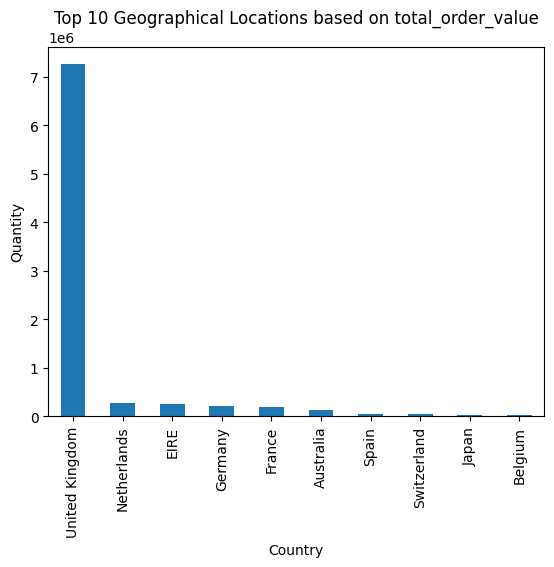

In [62]:
# Visualising the results
online_transactions_cl.groupby ('country')['total_order_value'].sum().sort_values(ascending=False).head(10).plot(kind = 'bar')
plt.title("Top 10 Geographical Locations based on total_order_value")
plt.xlabel("Country")
plt.ylabel("Quantity")
plt.show();

 Based of frequency or quantity or total_order_value, the United Kingdom is the country where the most sales take place.

#### 3.2 Seasonality
##### a. Distribution of invoices per year

In [30]:
# Extracting the year von invoice_date
online_transactions_cl['invoice_date']=online_transactions_cl['invoice_date'].dt.year

In [52]:
# display the first five rows of the data
online_transactions_cl.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,extracted_number
0,536384,22189,CREAM HEART CARD HOLDER,3.95,4,15.8,2010,u18074,United Kingdom,NaN
1,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,1.25,12,15.0,2010,u13705,United Kingdom,NaN
2,536401,22068,BLACK PIRATE TREASURE CHEST,1.65,2,3.3,2010,u15862,United Kingdom,NaN
3,536412,22961,JAM MAKING SET PRINTED,1.45,24,34.8,2010,u1792,United Kingdom,NaN
4,536420,21889,WOODEN BOX OF DOMINOES,1.25,12,15.0,2010,u16583,United Kingdom,NaN


In [32]:
# grouping the data by the 'invoice_date' column and then counting the number of invoices of each date using the 'invoice' column.
invoice_year=online_transactions_cl.groupby('invoice_date')['invoice'].count()
# resetting the index of the invoice_year Series and renaming the columns.
invoice_year=invoice_year.reset_index().rename(columns={'invoice_date':'year'})
invoice_year

,year,invoice
0,2010,25581
1,2011,365753


<Figure size 1500x800 with 0 Axes>

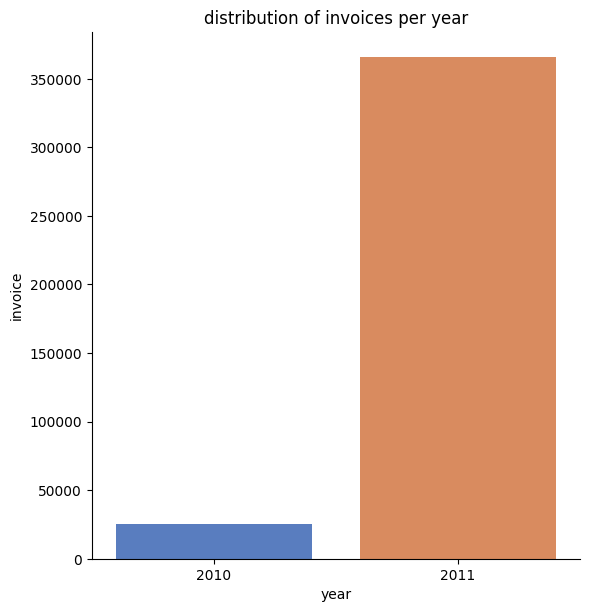

In [33]:
#Visualising the results
import matplotlib.pyplot as plt
import seaborn as sns

#Create a figure with a specified size
fig = plt.figure(figsize = [15, 8]) 

#create a bar plot 
sns.catplot(x = 'year', y = 'invoice', data = invoice_year, height=6, kind="bar", palette="muted") 
 
#Adds labels
plt.xlabel("year") 
plt.ylabel("invoice")
plt.title('distribution of invoices per year') 

#displays the plot
plt.show()

#### The most sales are in year 2011. therfore just this year will be analysed.

In [34]:
# filtering the data where the 'invoice_date' is equal to the year 2011.
online_transactions_cl_2011=online_transactions_cl.loc[online_transactions_cl['invoice_date']==2011]

In [35]:
# display the first five rows of the data
online_transactions_cl_2011.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,extracted_number
1313,540014,22179,SET 10 NIGHT OWL LIGHTS,6.75,1,6.75,2011,u14606,United Kingdom,NaN
1314,540023,84406B,CREAM CUPID HEARTS COAT HANGER,3.25,2,6.50,2011,u15039,United Kingdom,NaN
1315,540033,22692,DOORMAT WELCOME TO OUR HOME,7.95,1,7.95,2011,u1368,United Kingdom,NaN
1316,540096,22473,TV DINNER TRAY VINTAGE PAISLEY,1.95,16,31.20,2011,u13253,United Kingdom,NaN
1317,540115,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,2.55,9,22.95,2011,u15235,United Kingdom,NaN


##### b. Distribution of invoices per month

In [37]:
# Using SQL query that does the following:
# .counting the number of invoices for each customer in the year 2011 where the quantity is greater than 0.
# .extracting the year, month, day, and hour from the 'invoice_date' column.

query="""select customer_id,
                count('invoice') as invoice_count,
                date_part('year',invoice_date) as invoice_year,
                date_part('month',invoice_date)as invoice_month        
        from bootcamp.online_transactions_cleaned otc
        where invoice_year= 2011 and quantity>0
        group by customer_id,invoice_year, invoice_month,invoice_date 
        order by invoice_year, invoice_month;"""

# read the result into a Pandas DataFrame
online_trans_time_dis= pd.read_sql(query,connect)
## display the data
online_trans_time_dis.round(0).head()

,customer_id,invoice_count,invoice_year,invoice_month
0,u15039,45,2011.0,1.0
1,u14606,57,2011.0,1.0
2,u1368,49,2011.0,1.0
3,u13253,16,2011.0,1.0
4,u15235,8,2011.0,1.0


In [38]:
# Checking the data types
online_trans_time_dis.dtypes

customer_id       object
invoice_count      int64
invoice_year     float64
invoice_month    float64
dtype: object

In [40]:
#  converting some columns in the online_trans_time_dis DataFrame to integer types
online_trans_time_dis['invoice_year']=online_trans_time_dis['invoice_year'].astype(int)
online_trans_time_dis['invoice_month']=online_trans_time_dis['invoice_month'].astype(int)
# checking the data types of the columns
online_trans_time_dis.dtypes

customer_id      object
invoice_count     int64
invoice_year      int32
invoice_month     int32
dtype: object

In [41]:
# display the first five rows of the data
online_trans_time_dis.head()

,customer_id,invoice_count,invoice_year,invoice_month
0,u15039,45,2011,1
1,u14606,57,2011,1
2,u1368,49,2011,1
3,u13253,16,2011,1
4,u15235,8,2011,1


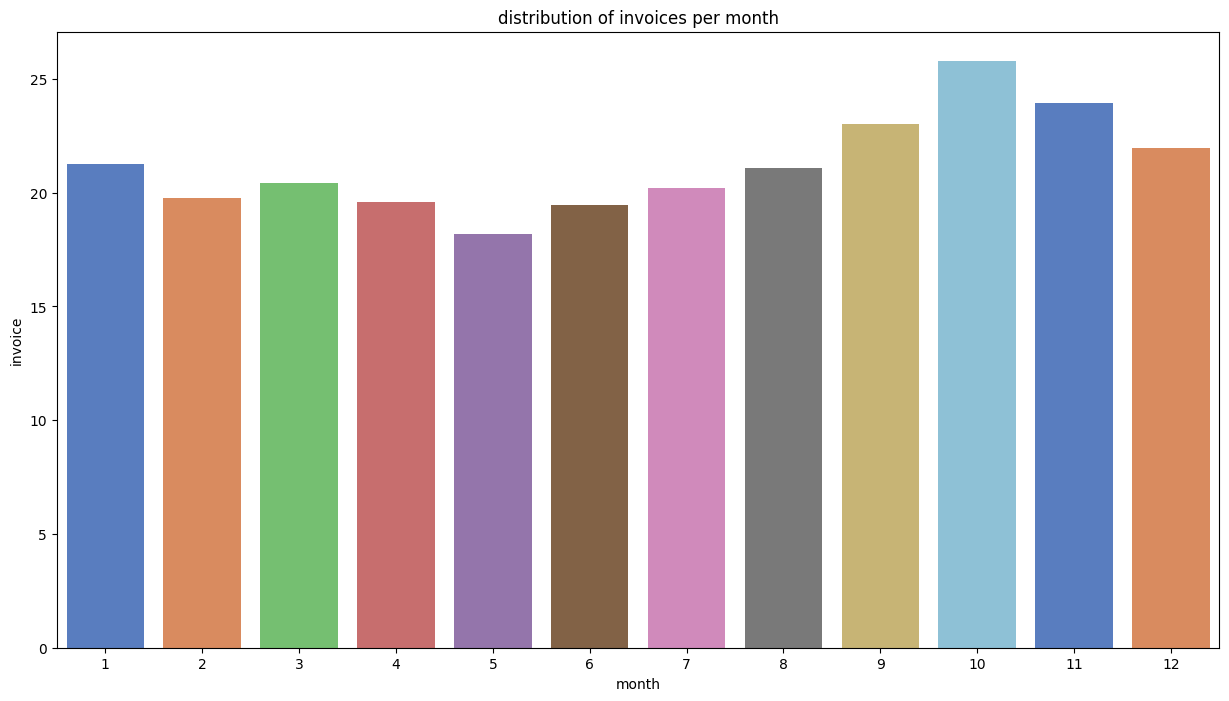

In [42]:
# Visualizing the results
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with a specified size
fig = plt.figure(figsize = [15, 8])

#create a bar plot 
sns.barplot(x ='invoice_month' , y = 'invoice_count', data = online_trans_time_dis, ci=None, palette="muted") 

#Adds labels
plt.xlabel("month") 
plt.ylabel("invoice")
plt.title('distribution of invoices per month') 

#displays the plot.
plt.show()


#### We can deduce that the highest sales are in the months Sebtember, Oktober and November. In this Time the customers are preparing for Christmas.

##### c. Distribution of invoices per weekdays

In [43]:
query="""SELECT
    customer_id,
    count('invoice') as invoice_count,    
    invoice_date,
    CASE
        WHEN date_part('dow', invoice_date) = 1 THEN 'Monday'
        WHEN date_part('dow', invoice_date) = 2 THEN 'Tuesday'
        WHEN date_part('dow', invoice_date) = 3 THEN 'Wednesday'
        WHEN date_part('dow', invoice_date) = 4 THEN 'Thursday'
        WHEN date_part('dow', invoice_date) = 5 THEN 'Friday'
        WHEN date_part('dow', invoice_date) = 6 THEN 'Saturday'
        WHEN date_part('dow', invoice_date) = 0 THEN 'Sunday'
        ELSE 'Unknown'
    END AS invoice_day,
    CASE
        WHEN EXTRACT(HOUR FROM invoice_date) < 12 THEN 'Morning'
        ELSE 'Evening'
    END AS Daytimes
FROM bootcamp.online_transactions_cleaned otc
group by customer_id,invoice_date 
order by invoice_date ;"""
# read the result into a Pandas DataFrame
online_trans_day_dis= pd.read_sql(query,connect)
## display the data
online_trans_day_dis.round(0).head()


,customer_id,invoice_count,invoice_date,invoice_day,daytimes
0,u1785,7,2010-12-01 08:26:00,Wednesday,Morning
1,u1785,2,2010-12-01 08:28:00,Wednesday,Morning
2,u13047,16,2010-12-01 08:34:00,Wednesday,Morning
3,u13047,1,2010-12-01 08:35:00,Wednesday,Morning
4,u12583,19,2010-12-01 08:45:00,Wednesday,Morning


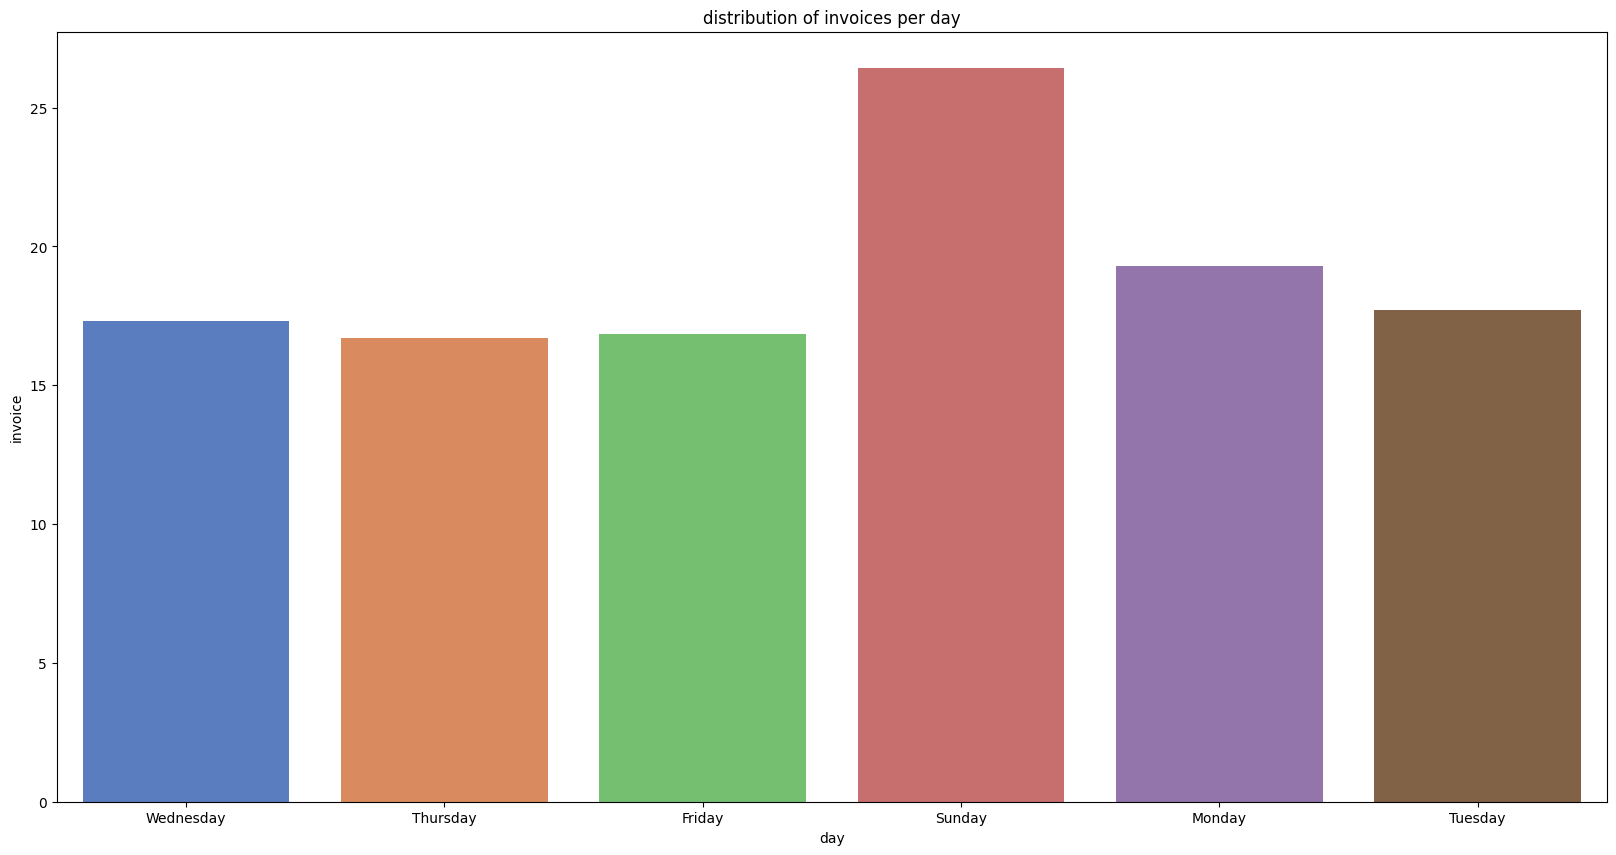

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize = [20, 10]) 

sns.barplot(x =('invoice_day') , y = 'invoice_count', data = online_trans_day_dis, ci=None,palette="muted") 
# height: scalar- Height (in inches) of each facet. 

plt.xlabel("day") 
plt.ylabel("invoice")
plt.title('distribution of invoices per weekday') 

plt.show()

##### d. Distribution of invoices per daytimes

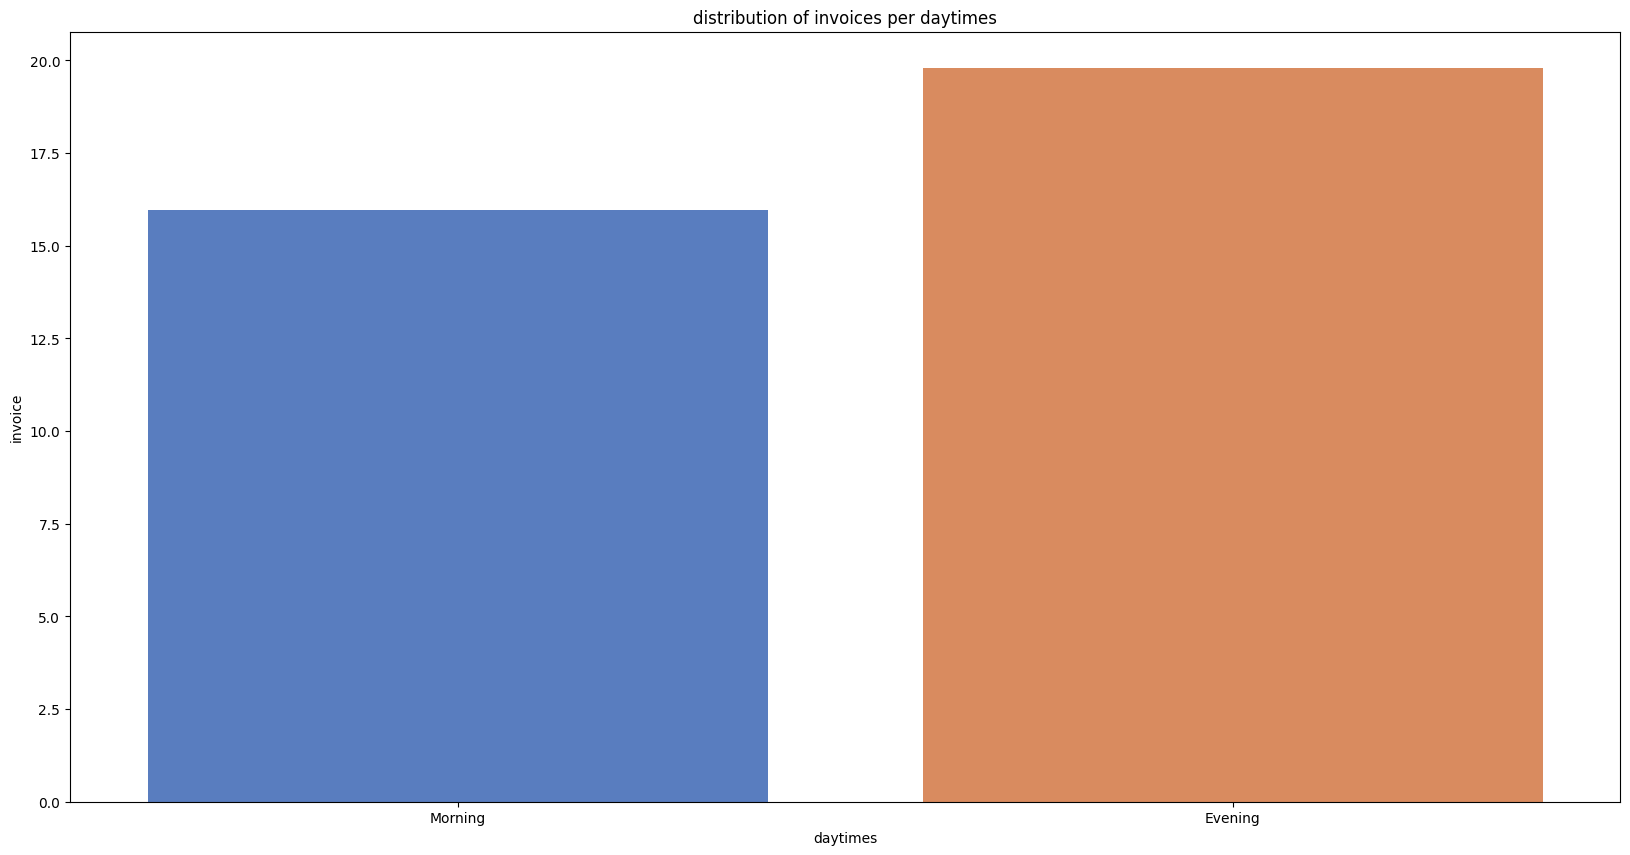

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize = [20, 10]) 

sns.barplot(x =('daytimes') , y = 'invoice_count', data = online_trans_day_dis, ci=None,palette="muted") 


plt.xlabel("daytimes") 
plt.ylabel("invoice")
plt.title('distribution of invoices per daytimes') 

plt.show()

#### we deduced also that the highest sales were recorded in the evenings of every day, espacially on Sundays.